In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

#  First steps with
<img src="https://pytorch.org/docs/stable/_static/pytorch-logo-dark.svg" width=800/>

## What is PyTorch ?
It’s a Python-based scientific computing package targeted at two sets of audiences:

- A replacement for NumPy to use the power of GPUs
- a deep learning research platform that provides maximum flexibility and speed


### PyTorch is deeply integrated into Python
- imperative programming: access and print variables anytime (those who tried tensorflow, keras, etc will appreciate :) )
- use python's usual debuging tools (same here :) )
- easily integrate with numpy, scipy, pandas, sklearn, etc

## Tensors and NumPy arrays
- Tensors $\sim$ numpy N-dimensinal arrays
  - Can be 0-dimensional (scalars)
  - Support for sparse tensors included
  - intentionally similar API: same function names and indexing, slicing and broadcasting conventions
- Tensors are loadable on GPU

<center>
    <img src="https://github.com/pytorch/pytorch/raw/master/docs/source/_static/img/tensor_illustration.png"
         width=800/>
    Source: https://github.com/pytorch/pytorch
</center>
  

**On Numpy**

In [2]:
import numpy as np
a = np.arange(5, dtype=np.int32)
b = 2*a   
a, b

(array([0, 1, 2, 3, 4], dtype=int32), array([0, 2, 4, 6, 8], dtype=int32))

**On torch**

In [3]:
import torch
a = torch.arange(5, dtype=torch.int32)
b = 2*a  
a, b

(tensor([0, 1, 2, 3, 4], dtype=torch.int32),
 tensor([0, 2, 4, 6, 8], dtype=torch.int32))

**In-place operations**
All in-place operators available as methods on tensor with `_` ending

In [4]:
  a

tensor([0, 1, 2, 3, 4], dtype=torch.int32)

In [5]:
a.add_(1)  # in-place methods return self

tensor([1, 2, 3, 4, 5], dtype=torch.int32)

In [6]:
a.sub_(1).mul_(2) # so we can chain them

tensor([0, 2, 4, 6, 8], dtype=torch.int32)

In [7]:
a.eq_(a)

tensor([1, 1, 1, 1, 1], dtype=torch.int32)

In [8]:
a = torch.arange(5, dtype=torch.int32)

### Easy conversion between frameworks
- shared memeory between numpy arrays and cpu tensors

In [9]:
a_numpy = a.numpy()
a_numpy += 1  # torch tensor a will also be modified
print("torch: ", a, 
      "\nnumpy: ",a_numpy)

torch:  tensor([1, 2, 3, 4, 5], dtype=torch.int32) 
numpy:  [1 2 3 4 5]


* create tensor from numpy array

In [10]:
a_numpy2tensor = torch.from_numpy(a_numpy)
a_numpy2tensor += 1  # numpy array will also be modified
print("torch: ", a_numpy2tensor, 
      "\nnumpy: ",a_numpy)

torch:  tensor([2, 3, 4, 5, 6], dtype=torch.int32) 
numpy:  [2 3 4 5 6]


### An operation on GPU
First let's time it on cpu

In [11]:
N = 1000
a = np.random.rand(N,N).astype(np.float32)
x = np.arange(N, dtype=np.float32)
%timeit y = a*x

882 µs ± 162 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
N = 1000
a = torch.rand(N,N, dtype=torch.float32)
x = torch.arange(N, dtype=torch.float32)
%timeit y = a*x

809 µs ± 60.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Now we do the same on gpu 

In [13]:
torch.cuda.is_available()

True

In [14]:
a = torch.rand(N,N, dtype=torch.float32, device="cuda")
x = torch.arange(N, dtype=torch.float32, device="cuda")
%timeit y = a*x

127 µs ± 2.67 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


(pytorch binaries already include CUDA, CuDNN, NCCL, MKL, etc. - but you need to have Nvidia driver installed)

**Attention: from cuda to numpy**
1. bring tensor to cpu with `.cpu()`
2. then call `.numpy()`

In [15]:
y = a*x

In [16]:
y.numpy()

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [17]:
y.cpu().numpy()

array([[0.00000000e+00, 8.47667038e-01, 9.70036864e-01, ...,
        5.83619751e+02, 8.89175903e+02, 1.15892044e+02],
       [0.00000000e+00, 2.76412398e-01, 1.22722471e+00, ...,
        1.75498138e+02, 8.78239014e+02, 9.45720337e+02],
       [0.00000000e+00, 3.22977006e-01, 1.98101211e+00, ...,
        1.48793655e+02, 6.27703613e+02, 2.54500229e+02],
       ...,
       [0.00000000e+00, 4.28057730e-01, 9.21844661e-01, ...,
        8.97595825e+02, 5.86440918e+02, 9.10931885e+02],
       [0.00000000e+00, 9.28996563e-01, 1.85661256e+00, ...,
        8.38728088e+02, 6.05917786e+02, 6.31650757e+02],
       [0.00000000e+00, 1.14527941e-01, 1.42226708e+00, ...,
        1.75077759e+02, 3.80753593e+01, 3.76903900e+02]], dtype=float32)

## Autograd
- `requires_grad=True` enables tensor history tracking and allows for automatic differentiation
    - construction of a acyclic directed *computation graph* 
- For a given tensor `X`:
  - `X.grad_fn` object stores this tensor's gradient function
  - `X.grad_fn.next_functions` points to other gradient functions 


In [18]:
x = torch.ones(1, requires_grad=True)
y = x**2
print(y.grad_fn)

In [19]:
z = y + 3
print(z.grad_fn, z.grad_fn.next_functions)

<AddBackward object at 0x7fd0759e0278> ((<PowBackward0 object at 0x7fd0759f6860>, 0),)


### The `backward` method
- `backward` computes gradients with respect to graph leaves by chain-rule (starting from root)
- here: $z= y + 3 =x^2 + 3$ , so $\frac{dz}{dx} = \frac{dz}{dy}\frac{dy}{dx}=2x$ 
  - `z` is the root (on which we are calling backward)
  - `x` is the only leaf

In [20]:
z.backward()

- after the call:
  - `x.data` contains `x` values
  - `x.grad` will store gradients computed wrt. `x`

In [21]:
print('x: ', x.data)
print('dz/dx: ', x.grad)

x:  tensor([1.])
dz/dx:  tensor([2.])


- previously computation graph is erased (except if `retain_graph=True` is used)

In [22]:
#z.backward(x)

### Dynamic graphs
- A computation dependency graph allows automaticaly computing gradients by chain-rule
- Define-and-run: graph can be changed in the loop before next call to backward (flexibility!)
<center>
    <img 
         align="middle"
         src = "https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/dynamic_graph.gif"  
         width=900/>
    Source: https://github.com/pytorch/pytorch
</center>

### Example: a simple regression
- Goal: make `x` approach `target`
- gradient descent: update `x.data` in the oposite direction of `x.grad`

Let's pick a target (blue) and take a starting point (orange):

In [23]:
def plot(x, target):
    plt.plot(target.numpy(), 'o ', ms=20, label= 'target')
    plt.plot(x.data.numpy(), '* ', ms=20, label='variable x'); plt.legend()
    print('x: ', x, '\ntarget:', target)

x:  tensor([0.6167, 0.1571, 0.7954, 0.3265, 0.2101], requires_grad=True) 
target: tensor([0., 1., 2., 3., 4.])


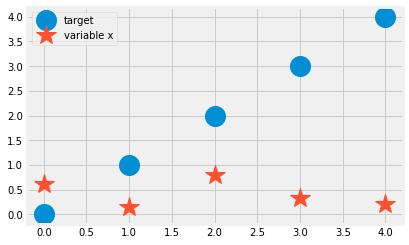

In [24]:
x = torch.rand(5, requires_grad=True)
target = torch.arange(5.0)

plot(x,target)

Then we loop over gradient computation and minimzation steps. 

**Note**: modificatios to `x.data` are not monitored by `autograd`.

x:  tensor([0.0014, 0.9982, 1.9974, 2.9941, 3.9917], requires_grad=True) 
target: tensor([0., 1., 2., 3., 4.])


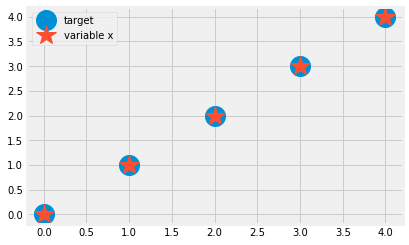

In [25]:
lr = learning_rate = 0.1
for _ in range(150):
    # compute squared distance between x and target
    distance = torch.mean(torch.pow((x - target), 2))
    distance.backward(retain_graph=True)
    # update x.data according to x.grad
    x.data -=  lr * x.grad.data
    # backward accumulates gradients, so zero them before next call to backward
    x.grad.zero_()  # (.zero_ method fills tensors with 0s in-place)

plot(x, target)

### Example: Logistic regression
Let's work on some synthetic data

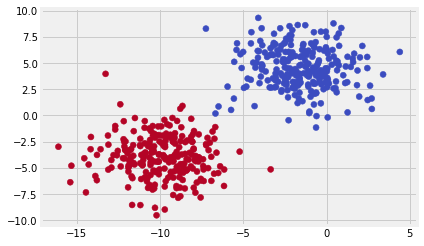

In [26]:
from sklearn.datasets import make_blobs

n_classes = 2
X, y = make_blobs(n_samples=500, n_features=2, centers=n_classes, 
                  cluster_std=2, random_state=1)
plt.scatter(*X.T, c=y, cmap='coolwarm')

#### Declare parameters to be adjusted
$$ y = \sigma (XW + b )$$
The logistic regression predictor has two parameters: 
- the weight matrix `W` and 
- the vector of intercepts `b`

In [27]:
n_samples, n_features = X.shape
# we can set random generator's seed
torch.manual_seed(0)
W = torch.rand(n_features, n_classes, # tensor shape
               dtype=torch.double, requires_grad=True)  

b = torch.zeros(n_classes, # tensor shape
                dtype=torch.double, requires_grad=True)


Since the graph for gradient computation is defyned by run, **all steps need to be recomputed at every iteration**.
We'll have the following steps:
- compute the logistic regressor predictions
- compute a loss function measuring the prediction error
- call `backward` on the `loss` tensor
- update `W.data` and `b.data` with the gradients `W.grad` and `b.grad`
- reset `W.grad` and `b.grad` to zero

In [28]:
# Loop to optimize
n_iterations = 500
lr = 0.1
loss_curve = []
for i in range(n_iterations):
    # compute the logistic regressor output
    X_tensor = torch.from_numpy(X)
    linear = torch.mm(X_tensor, W) + b
    y_pred = torch.sigmoid(linear)
    
    # Let's encode the true class labels in a matrix of class indicator vectors
    # (one-hot encoding) so we can compare to our predictions
    y_true = torch.zeros(n_samples, n_classes, dtype=y_pred.dtype)
    y_true.scatter_(1, torch.from_numpy(y).view(-1,1), 1.0)
    
    # Now we define a MSE loss function between predictions 
    loss = (y_pred-y_true).pow(2).mean()
    loss_curve.append(loss.data.numpy())
    # loss backward computes gradients
    loss.backward(retain_graph=True) 
    
    # Let's update the parameters with the respective gradients
    # the .sub_ method subtracts from the tensor in-place
    W.data.sub_(lr * W.grad.data)
    b.data.sub_(lr * b.grad.data)
    
    # reset gradients to zero
    W.grad.data.zero_()
    b.grad.data.zero_()

##### Results

In [29]:
def frontier_plot():
    # evenly sampled points
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    #plot background colors
    ax = plt.gca()
    new_x = np.c_[xx.ravel(), yy.ravel()]
    Z = torch.sigmoid(torch.from_numpy(new_x).mm(W)+b).data.numpy()[:, 1]
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap='coolwarm', alpha=.5)
    cs2 = ax.contour(xx, yy, Z, cmap='coolwarm', alpha=.5)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)


Final accuracy:  98.8


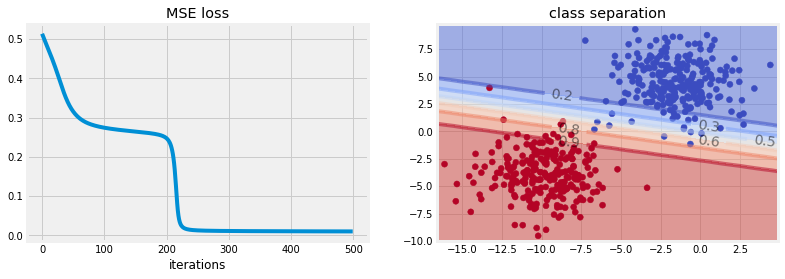

In [30]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss_curve)
plt.title('MSE loss'); plt.xlabel('iterations')
plt.subplot(1,2,2)
plt.title('class separation')
frontier_plot()
plt.scatter(*X.T, c=y, cmap='coolwarm')
y_pred_class = torch.argmax(y_pred, 1).detach().numpy()
print('Final accuracy: ', (y_pred_class == y).mean()*100)

## torch.nn 
- `torch.nn` contains many useful utilities for neural netwoks and ML models in general
- many commonly used layers and loss functions are already available

In [31]:
print('Avaliable modules/layers/losses in torch.nn')
print([n for n in dir(torch.nn) if not n.startswith('_')] )

Avaliable modules/layers/losses in torch.nn
['AdaptiveAvgPool1d', 'AdaptiveAvgPool2d', 'AdaptiveAvgPool3d', 'AdaptiveLogSoftmaxWithLoss', 'AdaptiveMaxPool1d', 'AdaptiveMaxPool2d', 'AdaptiveMaxPool3d', 'AlphaDropout', 'AvgPool1d', 'AvgPool2d', 'AvgPool3d', 'BCELoss', 'BCEWithLogitsLoss', 'BatchNorm1d', 'BatchNorm2d', 'BatchNorm3d', 'Bilinear', 'ConstantPad1d', 'ConstantPad2d', 'ConstantPad3d', 'Container', 'Conv1d', 'Conv2d', 'Conv3d', 'ConvTranspose1d', 'ConvTranspose2d', 'ConvTranspose3d', 'CosineEmbeddingLoss', 'CosineSimilarity', 'CrossEntropyLoss', 'CrossMapLRN2d', 'DataParallel', 'Dropout', 'Dropout2d', 'Dropout3d', 'ELU', 'Embedding', 'EmbeddingBag', 'FeatureAlphaDropout', 'Fold', 'FractionalMaxPool2d', 'GLU', 'GRU', 'GRUCell', 'GroupNorm', 'Hardshrink', 'Hardtanh', 'HingeEmbeddingLoss', 'InstanceNorm1d', 'InstanceNorm2d', 'InstanceNorm3d', 'KLDivLoss', 'L1Loss', 'LPPool1d', 'LPPool2d', 'LSTM', 'LSTMCell', 'LayerNorm', 'LeakyReLU', 'Linear', 'LocalResponseNorm', 'LogSigmoid', 'Lo

### nn.Module
- `nn.Module`: the basic unit. One must
  - declare params in the class constructor `__init__`
  - implement `forward` method returning the module's computation

In [32]:
from torch import nn

class MyModule(nn.Module):
    def __init__(self, args, **kwargs):
        # always call __init__ from parent Module
        super().__init__(args, **kwargs)  
        self.param1 
        self.param2
        
    def forward(self, X):
        # do some computation on X, for instance
        result = X.mean(1)
        return result
        

## torch.optim
Implements many commonly used gradient-based optimization algorithms

In [33]:
[n for n in dir(torch.optim) if not n.startswith('_')]

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 'lr_scheduler']

## Example using nn and optim: Simple neural network
Let's work on some synthetic data

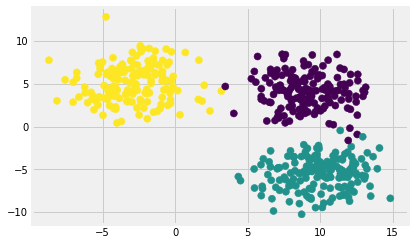

In [34]:
from sklearn.datasets import make_blobs
n_classes = 3
X, y = make_blobs(n_samples=500, n_features=2, centers=n_classes, 
                  cluster_std=2, random_state=24)
plt.scatter(*X.T, c=y, s=50)
X, y = X.astype(np.float32), y.astype(np.int64)


Let's create a module implementing a network with one hidden layer (aka MLP):
$$ y = W_o\sigma (XW_h + b )$$

We are going to use `nn.Linear` to compute linear transformations


In [35]:
  class MLP(nn.Module):
    def __init__(self, in_features, n_hidden, n_classes):
        # always call __init__ from parent Module
        super().__init__()
        
        # declare layers 
        # hidden layer contains Wh and b parameters
        self.hidden = nn.Linear(in_features, n_hidden, bias=True)
        # output layer contains Wo
        self.output = nn.Linear(n_hidden, n_classes, bias=False)
        
    def forward(self, X):
        # calling the layer automatically calls its forward method
        return self.output(torch.sigmoid(self.hidden(X)))

Now we create a network instancing the MLP module 

In [36]:
torch.manual_seed(0)
my_net = MLP(in_features=X.shape[1], n_hidden=6, n_classes=n_classes)
my_net

MLP(
  (hidden): Linear(in_features=2, out_features=6, bias=True)
  (output): Linear(in_features=6, out_features=3, bias=False)
)

We can see the networks parameters using the `parameters` or `named_parameters` methods.

In [37]:
print(list(my_net.named_parameters()))

[('hidden.weight', Parameter containing:
tensor([[-0.0053,  0.3793],
        [-0.5820, -0.5204],
        [-0.2723,  0.1896],
        [-0.0140,  0.5607],
        [-0.0628,  0.1871],
        [-0.2137, -0.1390]], requires_grad=True)), ('hidden.bias', Parameter containing:
tensor([-0.6755, -0.4683, -0.2915,  0.0262,  0.2795,  0.4243], requires_grad=True)), ('output.weight', Parameter containing:
tensor([[-0.2768, -0.1778,  0.1483,  0.3390, -0.0840,  0.3055],
        [-0.0658,  0.0432,  0.3697, -0.3787, -0.2570, -0.1034],
        [-0.1591,  0.3527, -0.2646, -0.1879, -0.2852, -0.3823]],
       requires_grad=True))]


Now we use an optimizer to adjust our network weights

In [38]:
optimizer = torch.optim.SGD(my_net.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

n_iterations = 800
loss_curve = []
for _ in range(n_iterations):
    # always zero gradients btw backward calls
    optimizer.zero_grad()

    # to compute a forward pass we simply call module instance 
    # the forward method is automatically called
    y_pred = my_net(torch.from_numpy(X))
    
    #call loss function over predictions and true labels
    loss = loss_fn(y_pred, torch.from_numpy(y))
    loss_curve.append(loss.cpu().data.numpy())
    
    # backpropagate gradients
    loss.backward()
    
    # increase iterator count in optimizer object
    optimizer.step()

### Results

Final accuracy:  99.2


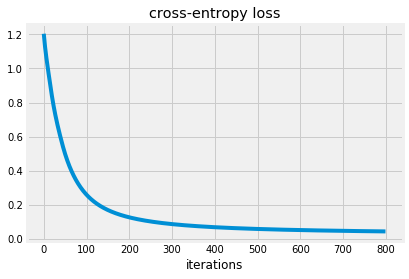

In [39]:
plt.plot(loss_curve)
plt.title('cross-entropy loss'); plt.xlabel('iterations')
y_pred_class = torch.argmax(y_pred, 1).cpu().data.numpy()
print('Final accuracy: ', (y_pred_class == y).mean()*100)

 
# To learn more
Many possibilities at https://pytorch.org/tutorials/
- [Learning PyTorch with Examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)
- [Deep Learning with PyTorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
- [Data Loading and Processing Tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
- [Chatbot Tutorial](https://pytorch.org/tutorials/beginner/chatbot_tutorial.html)
- [Reinforcement Learning (DQN) Tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

Also check the [migration guide to 0.4.0](https://pytorch.org/blog/pytorch-0_4_0-migration-guide/)

If you like scikit-learn, checkout [skorch=pytorch+sklearn](https://github.com/dnouri/skorch)

# Questions?